# Citibike Modeling w/ Facebook Prophet

In [1]:
import numpy as np
import pandas as pd
import pickle
import random
import datetime as dt
from datetime import datetime
from datetime import timedelta
import patsy
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import add_changepoints_to_plot

from helper_functions import mae, mape, rmse, plot_forecast, is_weekend, is_warm

## Forecast with Facebook Prophet

In [2]:
# read pickled dataframe
citibike_df = pd.read_pickle('data/citibike_df_preprocessed.pkl')

In [3]:
# add column for whether day is during weekend
citibike_df['is_weekend'] = [True if (x == 5 or x == 6) else False for x in citibike_df.day_of_week]
citibike_df['not_weekend'] = [False if (x == 5 or x == 6) else True for x in citibike_df.day_of_week]

# add column for whether day is in a warm month (may-sept)
citibike_df['is_warm'] = [True if x in [5,6,7,8,9] else False for x in citibike_df.month]
citibike_df['not_warm'] = [False if x in [5,6,7,8,9] else True for x in citibike_df.month]

# reorder columns
citibike_df = citibike_df[['date', 'station_id', 'station_name', 'station_latitude',
                           'station_longitude', 'mean_duration', 'year', 'month', 'day_of_week',
                           'is_weekend', 'not_weekend', 'is_warm', 'not_warm',
                           'ride_counts','replace_zeroes', 'ride_counts_clean']]

# drop some columns and reset index
citibike_df = citibike_df.drop(['ride_counts', 'replace_zeroes'], axis=1)
citibike_df = citibike_df.reset_index(drop=True)

In [57]:
# pickle dataframe
citibike_df.to_pickle('data/citibike_df_formatted.pkl')

In [4]:
# head of dataframe
citibike_df.head()

,date,station_id,station_name,station_latitude,station_longitude,mean_duration,year,month,day_of_week,is_weekend,not_weekend,is_warm,not_warm,ride_counts_clean
0,2015-01-01,79,Franklin St & W Broadway,40.719116,-74.006667,880.133333,2015,1,3,False,True,False,True,15
1,2015-01-02,79,Franklin St & W Broadway,40.719116,-74.006667,1499.818182,2015,1,4,False,True,False,True,22
2,2015-01-03,79,Franklin St & W Broadway,40.719116,-74.006667,432.266667,2015,1,5,True,False,False,True,15
3,2015-01-04,79,Franklin St & W Broadway,40.719116,-74.006667,693.666667,2015,1,6,True,False,False,True,27
4,2015-01-05,79,Franklin St & W Broadway,40.719116,-74.006667,669.000000,2015,1,0,False,True,False,True,27


In [5]:
# create dataframe for notable days including summer streets events and observance days
summer_streets = pd.DataFrame({
  'holiday': 'summer_streets',
  'ds': pd.to_datetime(['2015-08-01', '2015-08-08', '2015-08-15',
                        '2016-08-06', '2016-08-13', '2016-08-20',
                        '2017-08-05', '2017-08-12', '2017-08-19',
                        '2018-08-04', '2018-08-11', '2018-08-18',
                        '2019-08-03', '2019-08-10', '2019-08-17']),
  'lower_window': 0,
  'upper_window': 0,
})

mothers_day = pd.DataFrame({
  'holiday': 'mothers_day',
  'ds': pd.to_datetime(['2015-05-10', '2016-05-08', '2017-05-14', '2018-05-13', '2019-05-12']),
  'lower_window': 0,
  'upper_window': 0,
})

fathers_day = pd.DataFrame({
  'holiday': 'fathers_day',
  'ds': pd.to_datetime(['2015-06-21', '2016-06-19', '2017-06-18', '2018-06-17', '2019-06-16']),
  'lower_window': 0,
  'upper_window': 0,
})

holidays = pd.concat((summer_streets, mothers_day, fathers_day))

### Forecast select stations

#### E 24 St & Park Ave S (491):

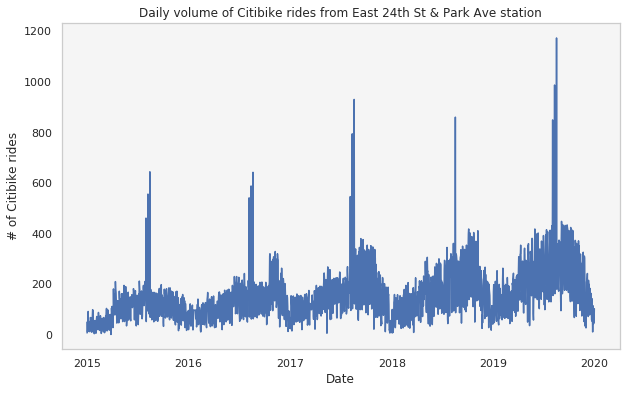

In [461]:
# plot daily ride counts for a specific station
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(citibike_df[citibike_df.station_id == 491].date, 
         citibike_df[citibike_df.station_id == 491].ride_counts_clean)
ax.set_facecolor('whitesmoke')
ax.title.set_text('Daily volume of Citibike rides from East 24th St & Park Ave station')
ax.set_xlabel('Date')
ax.set_ylabel('# of Citibike rides');

In [7]:
# split train and test for a select station 491
citibike_station = citibike_df.loc[citibike_df.station_id == 491, 
                                   ['date', 'is_weekend', 'not_weekend',
                                    'is_warm', 'not_warm', 'ride_counts_clean']] 

last_date = pd.Timestamp(2019, 12, 31) 
delta = timedelta(days = 364)
test_start_date = last_date - delta # test date begins 1/01/2019

station_cv = citibike_station.loc[(citibike_station.date < test_start_date), 
                                      ['date', 'is_weekend', 'not_weekend', 
                                       'is_warm', 'not_warm', 'ride_counts_clean']]

station_test = citibike_station.loc[(citibike_station.date >= test_start_date), 
                                  ['date', 'is_weekend', 'not_weekend', 
                                   'is_warm', 'not_warm', 'ride_counts_clean']]

station_cv.columns = ['ds', 'is_weekend', 'not_weekend', 'is_warm', 'not_warm', 'y']
station_test.columns = ['ds', 'is_weekend', 'not_weekend', 'is_warm', 'not_warm', 'y']

In [8]:
# create prophet object with parameters, fit with train data and do cross validation 
m = Prophet(daily_seasonality = 10, # True 5 20 100
            #weekly_seasonality = 5, # True 10 100
            yearly_seasonality = 5, # True 10 20 100!            
            holidays = holidays,
            seasonality_mode = 'multiplicative',
            seasonality_prior_scale = 10, #100
            holidays_prior_scale = 10, #) #100
            changepoint_prior_scale = 0.20) # .20 .15 .25

m.add_seasonality(name='monthly', period=30, fourier_order=10) # 5 100
m.add_seasonality(name='is_weekend', period=7, fourier_order=10, condition_name='is_weekend')
m.add_seasonality(name='not_weekend', period=7, fourier_order=3, condition_name='not_weekend')
m.add_seasonality(name='is_warm', period=30, fourier_order=3, condition_name='is_warm')
m.add_seasonality(name='not_warm', period=30, fourier_order=3, condition_name='not_warm')

m.add_country_holidays(country_name='US')

m.fit(station_cv)

cv_results = cross_validation(m, initial='730 days', horizon='365 days') 
print(cv_results)

INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-12-31 00:00:00 and 2017-12-31 00:00:00


             ds        yhat  yhat_lower  yhat_upper    y     cutoff
0    2017-01-01  -34.939923  -70.720941   -1.463568   33 2016-12-31
1    2017-01-02  155.259996  120.706955  188.798421   25 2016-12-31
2    2017-01-03  172.766661  136.381708  206.410836   33 2016-12-31
3    2017-01-04  173.896798  138.313593  206.010868  155 2016-12-31
4    2017-01-05  162.813927  126.264073  198.182928  133 2016-12-31
...         ...         ...         ...         ...  ...        ...
1090 2018-12-27  228.453889 -363.531142  830.337187  116 2017-12-31
1091 2018-12-28  177.645090 -285.964875  648.344596   43 2017-12-31
1092 2018-12-29   12.024510  -40.510703   63.518083   50 2017-12-31
1093 2018-12-30   14.302089  -45.788460   72.013648   50 2017-12-31
1094 2018-12-31  173.693418 -283.192352  642.068052   59 2017-12-31

[1095 rows x 6 columns]


In [366]:
# evaluation metrics
performance_results = performance_metrics(cv_results, metrics=['mae', 'mape', 'rmse'])
print("Mean MAE:", np.mean(performance_results.mae))
print("Mean MAPE:", np.mean(performance_results.mape))
print("Mean RMSE:", np.mean(performance_results.rmse))

Mean MAE: 64.56165688184079
Mean MAPE: 0.6874501343140363
Mean RMSE: 82.78038221500934


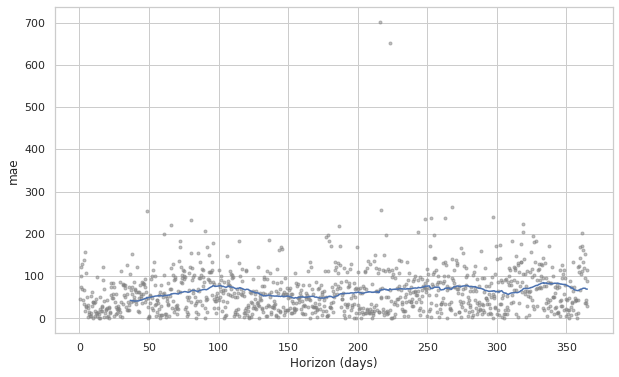

In [368]:
fig = plot_cross_validation_metric(cv_results, metric='mae')

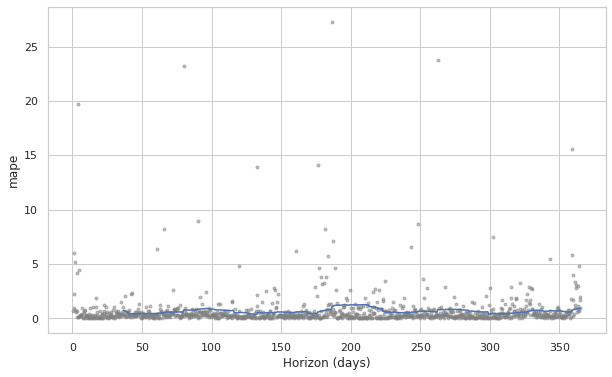

In [369]:
fig = plot_cross_validation_metric(cv_results, metric='mape')

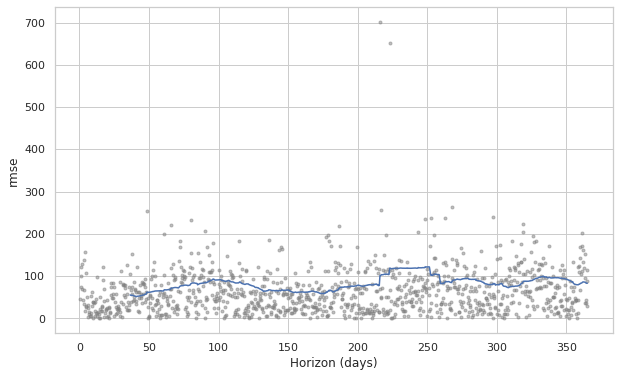

In [367]:
fig = plot_cross_validation_metric(cv_results, metric='rmse')

**With final model, make predictions on test set (2019)**

In [10]:
# create prophet object with parameters, fit with entire train data and predict on test set
m = Prophet(daily_seasonality = 10, # True 5 20 100
            #weekly_seasonality = 5, # True 10 100
            yearly_seasonality = 5, # True 10 20 100!            
            holidays = holidays,
            seasonality_mode = 'multiplicative',
            seasonality_prior_scale = 10, #100
            holidays_prior_scale = 10, #) #100
            changepoint_prior_scale = 0.20) # .20 .15 .25

m.add_seasonality(name='monthly', period=30, fourier_order=10) # 5 100
m.add_seasonality(name='is_weekend', period=7, fourier_order=10, condition_name='is_weekend')
m.add_seasonality(name='not_weekend', period=7, fourier_order=3, condition_name='not_weekend')
m.add_seasonality(name='is_warm', period=30, fourier_order=3, condition_name='is_warm')
m.add_seasonality(name='not_warm', period=30, fourier_order=3, condition_name='not_warm')

m.add_country_holidays(country_name='US')

# fit model to entire training data
m.fit(station_cv)

# predict using test set
future = m.make_future_dataframe(periods=365, freq='d') # 181 # include_history=False) 
future['is_weekend'] = future['ds'].apply(is_weekend)
future['not_weekend'] = ~future['ds'].apply(is_weekend)
future['is_warm'] = future['ds'].apply(is_warm)
future['not_warm'] = ~future['ds'].apply(is_warm)

forecast = m.predict(future)

In [11]:
# merge predictions back to main dataframe
citibike_pred = citibike_df[(citibike_df.station_id == 491) & 
                            (citibike_df.year == 2019)].merge( 
    forecast[['ds','yhat','yhat_lower','yhat_upper']], how='left', left_on=['date'], right_on=['ds'])

citibike_pred = citibike_pred.drop(['ds', 'year', 'month'], axis=1) 

citibike_pred.yhat = citibike_pred.yhat.apply(np.ceil).astype(int)

citibike_pred['error'] = citibike_pred.yhat - citibike_pred.ride_counts_clean
citibike_pred['error_abs'] = abs(citibike_pred.yhat - citibike_pred.ride_counts_clean).astype(int)
citibike_pred['error_sq'] = ((citibike_pred.yhat - citibike_pred.ride_counts_clean)**2).astype(int)

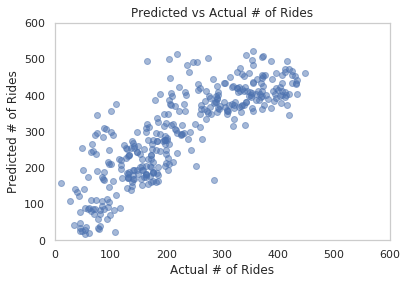

In [372]:
# plot predicted vs actual
plt.scatter(citibike_pred.ride_counts_clean, citibike_pred.yhat, alpha=0.5)
plt.title("Predicted vs Actual # of Rides"), plt.xlabel("Actual # of Rides"), plt.ylabel("Predicted # of Rides")
plt.xlim(0, 600), plt.ylim(0, 600);

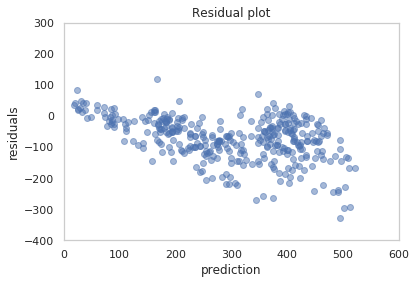

In [373]:
# plot residuals
residuals = citibike_pred.ride_counts_clean - citibike_pred.yhat
plt.scatter(citibike_pred.yhat, residuals, alpha=0.5)
plt.title("Residual plot"), plt.xlabel("prediction"), plt.ylabel("residuals")
plt.xlim(0, 600), plt.ylim(-400, 300);

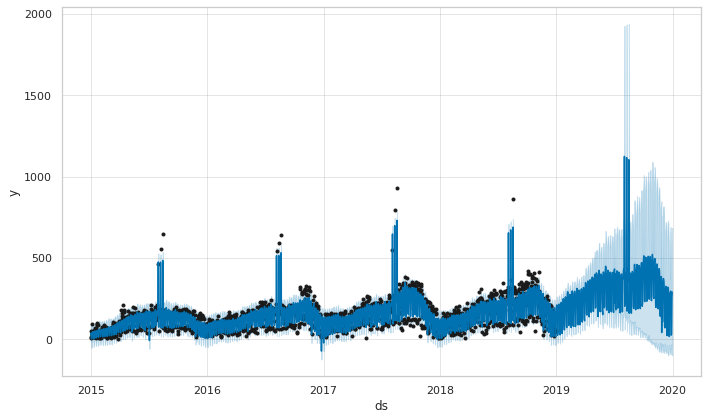

In [374]:
# plot forecast dataframe
fig1 = m.plot(forecast) 

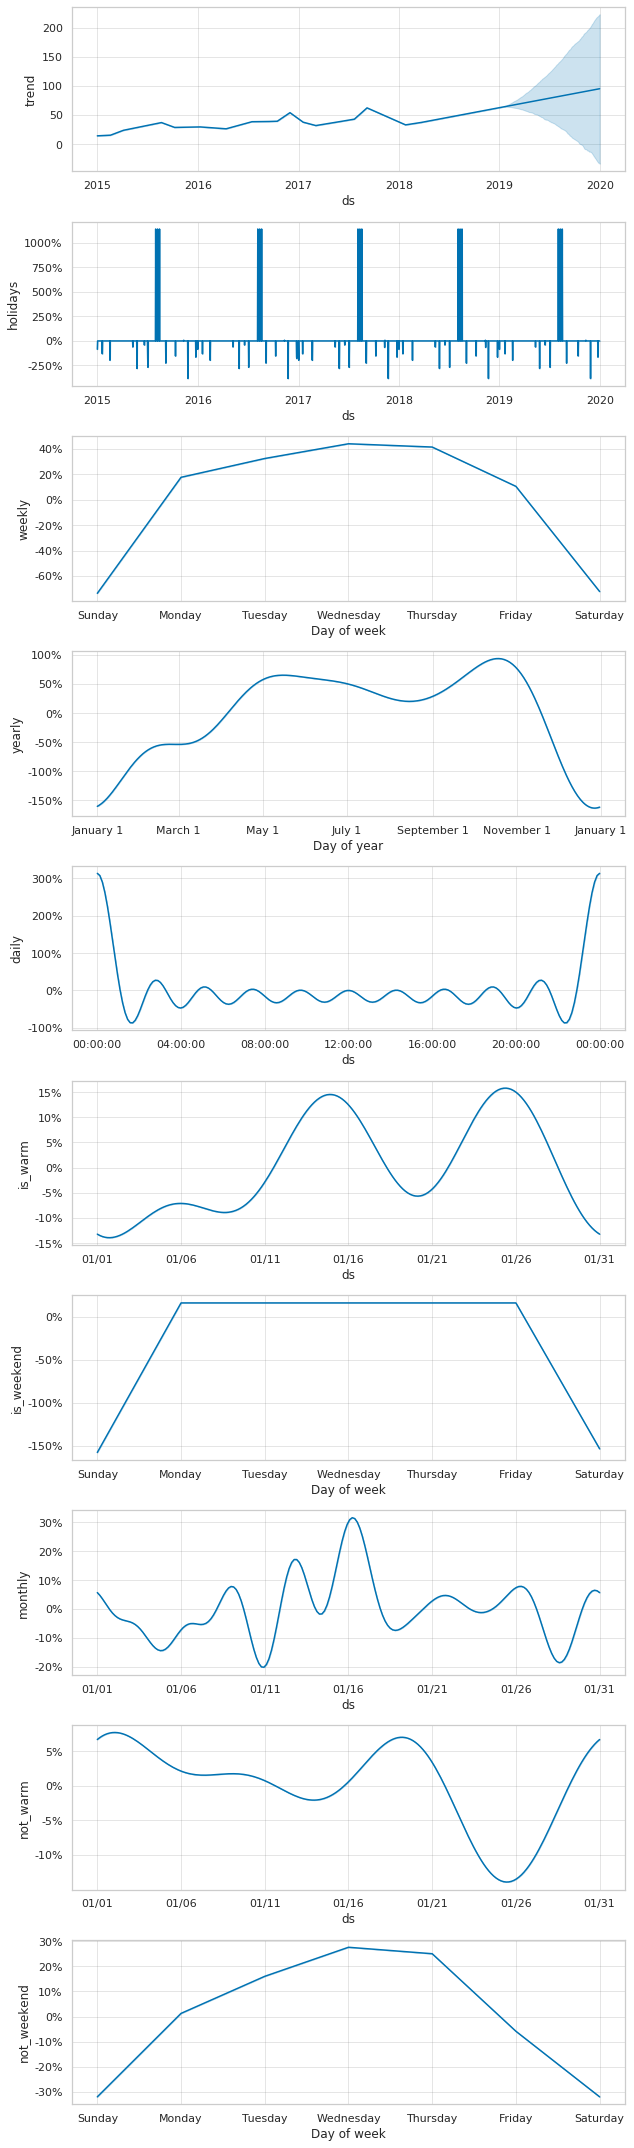

In [375]:
# plot forecast components
fig2 = m.plot_components(forecast)

In [376]:
# evaluation metrics
print("MAE:", mae(citibike_pred.ride_counts_clean, citibike_pred.yhat).round(3))
print("MAPE:", mape(citibike_pred.ride_counts_clean, citibike_pred.yhat).round(3))
print("RMSE:", rmse(citibike_pred.ride_counts_clean, citibike_pred.yhat).round(3))

MAE: 78.797
MAPE: 53.321
RMSE: 101.032


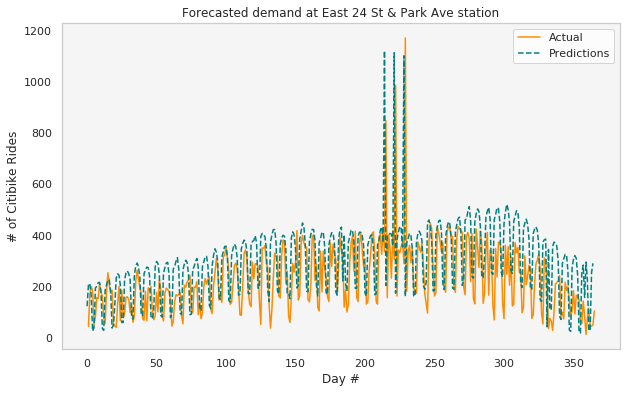

In [388]:
# plot predictions vs actual
plot_forecast(citibike_pred.ride_counts_clean, citibike_pred.yhat, title='Forecasted demand at East 24 St & Park Ave station')

#### W 31 St & 7 Ave (379):

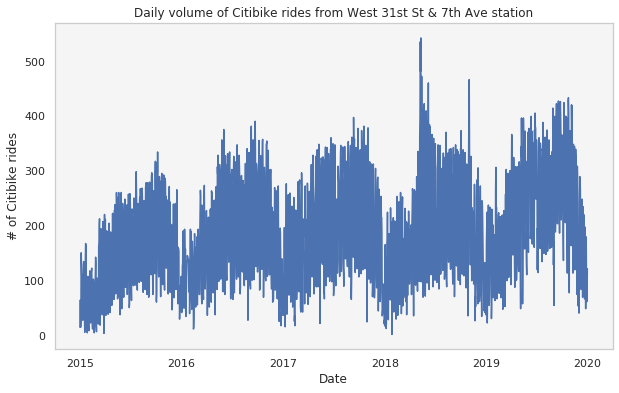

In [462]:
# plot daily ride counts for a specific station
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(citibike_df[citibike_df.station_id == 379].date, 
         citibike_df[citibike_df.station_id == 379].ride_counts_clean)
ax.set_facecolor('whitesmoke')
ax.title.set_text('Daily volume of Citibike rides from West 31st St & 7th Ave station')
ax.set_xlabel('Date')
ax.set_ylabel('# of Citibike rides');

In [389]:
# split train, validation and test for a select station 379
citibike_station = citibike_df.loc[citibike_df.station_id == 379, 
                                   ['date', 'is_weekend', 'not_weekend',
                                    'is_warm', 'not_warm', 'ride_counts_clean']] 

last_date = pd.Timestamp(2019, 12, 31) 
delta = timedelta(days = 364)
test_start_date = last_date - delta # test date begins 1/01/2019

station_cv = citibike_station.loc[(citibike_station.date < test_start_date), 
                                      ['date', 'is_weekend', 'not_weekend', 
                                       'is_warm', 'not_warm', 'ride_counts_clean']]

station_test = citibike_station.loc[(citibike_station.date >= test_start_date), 
                                  ['date', 'is_weekend', 'not_weekend', 
                                   'is_warm', 'not_warm', 'ride_counts_clean']]

station_cv.columns = ['ds', 'is_weekend', 'not_weekend', 'is_warm', 'not_warm', 'y']
station_test.columns = ['ds', 'is_weekend', 'not_weekend', 'is_warm', 'not_warm', 'y']

In [390]:
# create prophet object with parameters, fit with train data and predict future
m = Prophet(daily_seasonality = 10, # True 5 20 100
            #weekly_seasonality = 5, # True 10 100
            yearly_seasonality = 5, # True 10 20 100!            
            holidays = holidays,
            seasonality_mode = 'multiplicative',
            seasonality_prior_scale = 10, #100
            holidays_prior_scale = 10, #100
            changepoint_prior_scale = 0.2) # .15 .25

m.add_seasonality(name='monthly', period=30, fourier_order=10) # 5 100
m.add_seasonality(name='is_weekend', period=7, fourier_order=10, condition_name='is_weekend')
m.add_seasonality(name='not_weekend', period=7, fourier_order=3, condition_name='not_weekend')
m.add_seasonality(name='is_warm', period=30, fourier_order=3, condition_name='is_warm')
m.add_seasonality(name='not_warm', period=30, fourier_order=3, condition_name='not_warm')

m.add_country_holidays(country_name='US')

m.fit(station_cv)

cv_results = cross_validation(m, initial='730 days', horizon='365 days') 
print(cv_results)

INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-12-31 00:00:00 and 2017-12-31 00:00:00


             ds        yhat  yhat_lower  yhat_upper    y     cutoff
0    2017-01-01  -35.732487  -79.915158   11.989037   37 2016-12-31
1    2017-01-02  164.081355  119.976091  207.539499   39 2016-12-31
2    2017-01-03  191.033504  145.039598  236.400452  106 2016-12-31
3    2017-01-04  192.506860  142.912447  236.222055  166 2016-12-31
4    2017-01-05  181.565320  137.443822  223.232165  197 2016-12-31
...         ...         ...         ...         ...  ...        ...
1090 2018-12-27  143.967859 -221.962060  505.475732  133 2017-12-31
1091 2018-12-28  111.792521 -174.244960  397.092739   42 2017-12-31
1092 2018-12-29   21.431992  -53.921043   94.343590   79 2017-12-31
1093 2018-12-30   23.370476  -57.304511  104.903864   85 2017-12-31
1094 2018-12-31  114.991772 -190.041294  402.252061   38 2017-12-31

[1095 rows x 6 columns]


In [391]:
# evaluation metrics
performance_results = performance_metrics(cv_results, metrics=['mae', 'mape', 'rmse'])
print("Mean MAE:", np.mean(performance_results.mae))
print("Mean MAPE:", np.mean(performance_results.mape))
print("Mean RMSE:", np.mean(performance_results.rmse))

Mean MAE: 116.95720528865138
Mean MAPE: 0.7834799938396732
Mean RMSE: 139.3493894229544


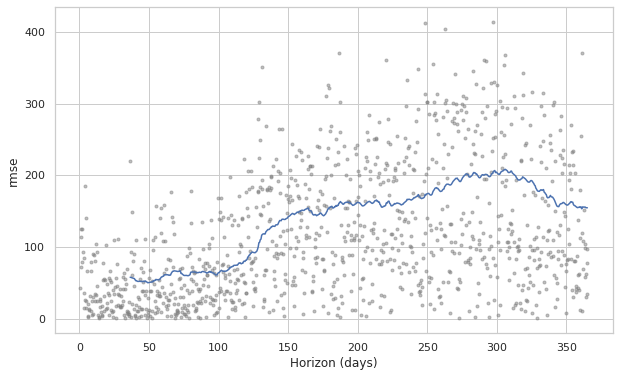

In [392]:
fig = plot_cross_validation_metric(cv_results, metric='rmse')

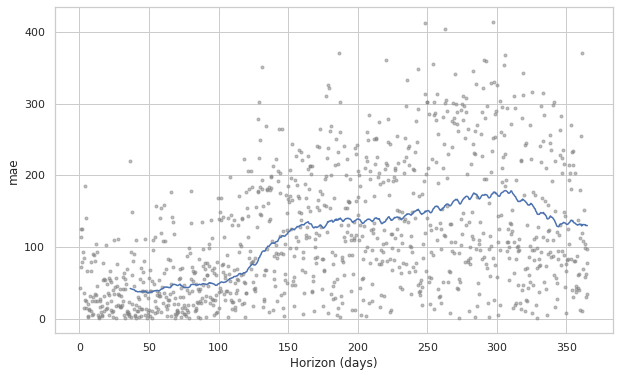

In [393]:
fig = plot_cross_validation_metric(cv_results, metric='mae')

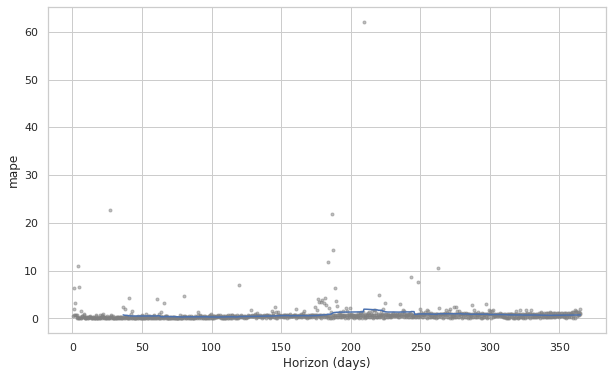

In [394]:
fig = plot_cross_validation_metric(cv_results, metric='mape')

**With final model, make predictions on test set (2019)**

In [395]:
# create prophet object with parameters, fit with train data and predict future
m = Prophet(daily_seasonality = 10, # True 5 20 100
            #weekly_seasonality = 5, # True 10 100
            yearly_seasonality = 5, # True 10 20 100!            
            holidays = holidays,
            seasonality_mode = 'multiplicative',
            seasonality_prior_scale = 10, #100
            holidays_prior_scale = 10, #) #100
            changepoint_prior_scale = 0.20) # .15 .25

m.add_seasonality(name='monthly', period=30, fourier_order=10) # 5 100
m.add_seasonality(name='is_weekend', period=7, fourier_order=10, condition_name='is_weekend')
m.add_seasonality(name='not_weekend', period=7, fourier_order=3, condition_name='not_weekend')
m.add_seasonality(name='is_warm', period=30, fourier_order=3, condition_name='is_warm')
m.add_seasonality(name='not_warm', period=30, fourier_order=3, condition_name='not_warm')

m.add_country_holidays(country_name='US')

# fit model to entire training data
m.fit(station_cv)

# predict using test set
future = m.make_future_dataframe(periods=365, freq='d') # 181 # include_history=False) 
future['is_weekend'] = future['ds'].apply(is_weekend)
future['not_weekend'] = ~future['ds'].apply(is_weekend)
future['is_warm'] = future['ds'].apply(is_warm)
future['not_warm'] = ~future['ds'].apply(is_warm)

forecast = m.predict(future)

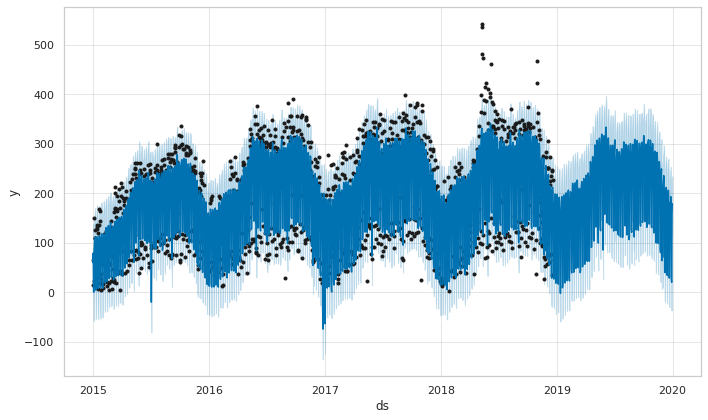

In [396]:
# plot forecast dataframe
fig1 = m.plot(forecast) 

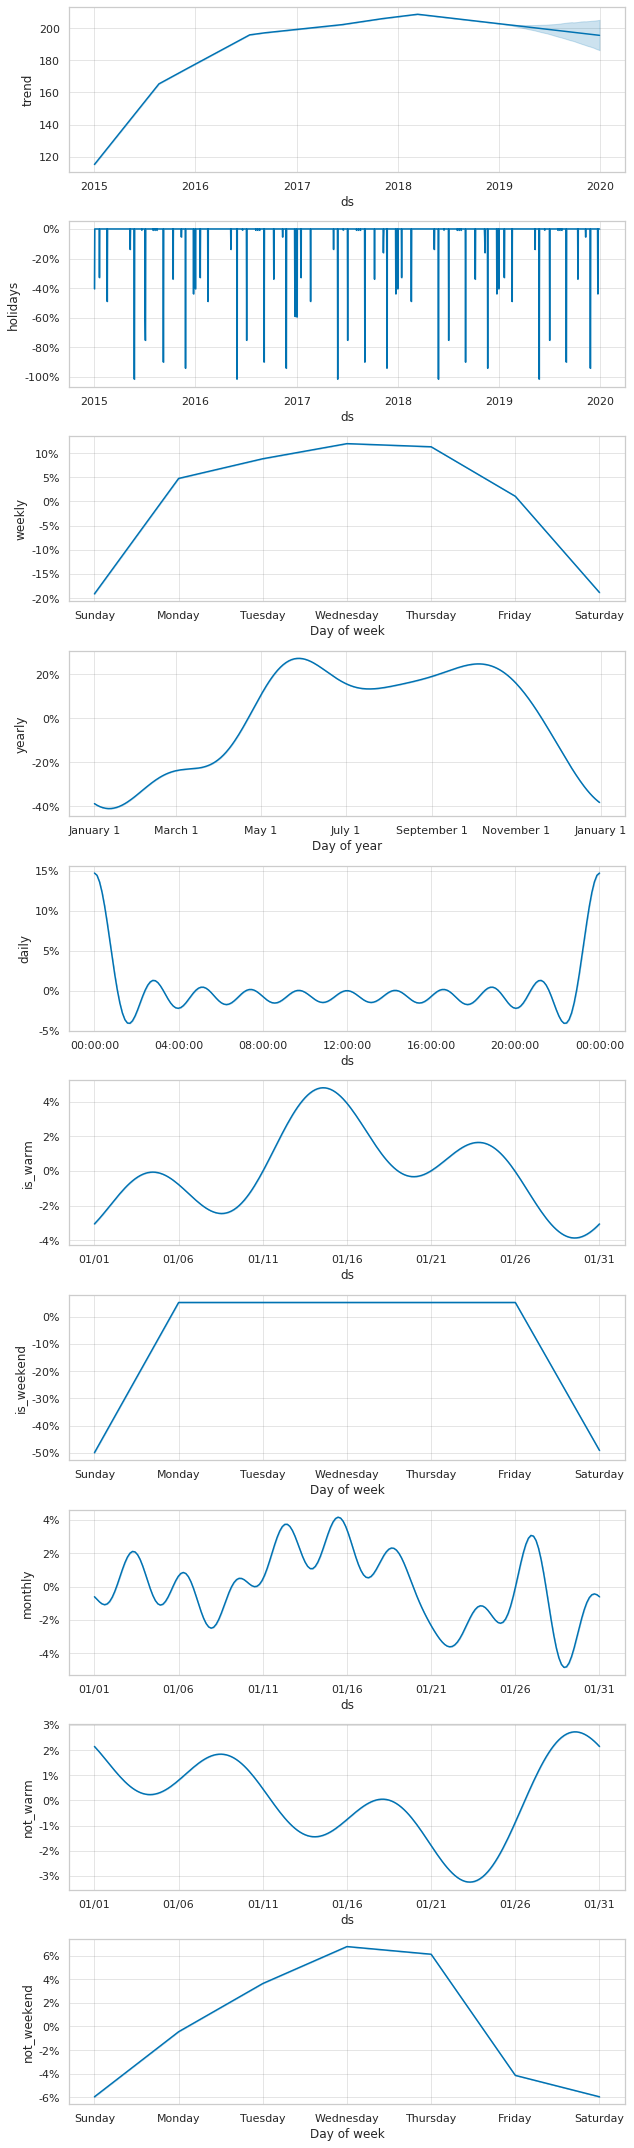

In [397]:
# plot forecast components
fig2 = m.plot_components(forecast)

In [398]:
# merge predictions back to main dataframe
citibike_pred = citibike_df[(citibike_df.station_id == 379) & 
                            (citibike_df.year == 2019)].merge( 
    forecast[['ds','yhat','yhat_lower','yhat_upper']], how='left', left_on=['date'], right_on=['ds'])

citibike_pred = citibike_pred.drop(['ds', 'year', 'month'], axis=1) # 'replace_zeroes'

citibike_pred.yhat = citibike_pred.yhat.apply(np.ceil).astype(int)

citibike_pred['error'] = citibike_pred.yhat - citibike_pred.ride_counts_clean
citibike_pred['error_abs'] = abs(citibike_pred.yhat - citibike_pred.ride_counts_clean).astype(int)
citibike_pred['error_sq'] = ((citibike_pred.yhat - citibike_pred.ride_counts_clean)**2).astype(int)

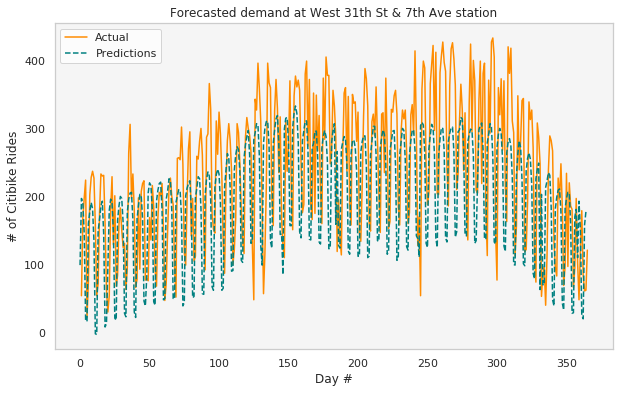

In [403]:
plot_forecast(citibike_pred.ride_counts_clean, citibike_pred.yhat, title='Forecasted demand at West 31th St & 7th Ave station')

In [400]:
# evaluation metrics
print("MAE:", mae(citibike_pred.ride_counts_clean, citibike_pred.yhat).round(3))
print("MAPE:", mape(citibike_pred.ride_counts_clean, citibike_pred.yhat).round(3))
print("RMSE:", rmse(citibike_pred.ride_counts_clean, citibike_pred.yhat).round(3))

MAE: 54.666
MAPE: 27.807
RMSE: 64.842


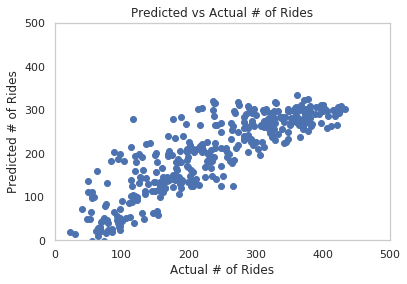

In [401]:
# plot predicted vs actual
plt.scatter(citibike_pred.ride_counts_clean, citibike_pred.yhat)
plt.title("Predicted vs Actual # of Rides"), plt.xlabel("Actual # of Rides"), plt.ylabel("Predicted # of Rides")
plt.xlim(0, 500), plt.ylim(0, 500);

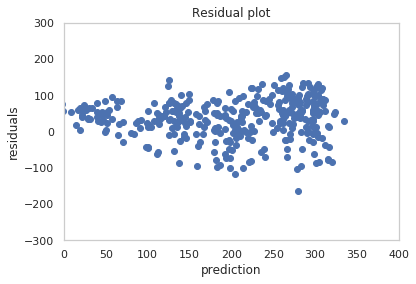

In [402]:
# plot residuals
residuals = citibike_pred.ride_counts_clean - citibike_pred.yhat
plt.scatter(citibike_pred.yhat, residuals, alpha=1.0)
plt.title("Residual plot"), plt.xlabel("prediction"), plt.ylabel("residuals")
plt.xlim(0, 400), plt.ylim(-300, 300);

#### Broadway & W 60 St (499)

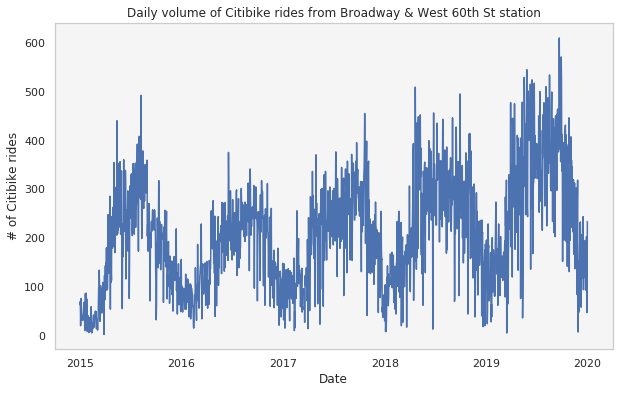

In [486]:
# plot daily ride counts for a specific station
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(citibike_df[citibike_df.station_id == 499].date, 
         citibike_df[citibike_df.station_id == 499].ride_counts_clean)
ax.set_facecolor('whitesmoke')
ax.title.set_text('Daily volume of Citibike rides from Broadway & West 60th St station')
ax.set_xlabel('Date')
ax.set_ylabel('# of Citibike rides');

In [23]:
# split train and test for station 499
citibike_station = citibike_df.loc[citibike_df.station_id == 499, 
                                   ['date', 'is_weekend', 'not_weekend',
                                    'is_warm', 'not_warm', 'ride_counts_clean']] 

last_date = pd.Timestamp(2019, 12, 31) 
delta = timedelta(days = 364)
test_start_date = last_date - delta # test date begins 1/01/2019

station_cv = citibike_station.loc[(citibike_station.date < test_start_date), 
                                      ['date', 'is_weekend', 'not_weekend', 
                                       'is_warm', 'not_warm', 'ride_counts_clean']]

station_test = citibike_station.loc[(citibike_station.date >= test_start_date), 
                                  ['date', 'is_weekend', 'not_weekend', 
                                   'is_warm', 'not_warm', 'ride_counts_clean']]

station_cv.columns = ['ds', 'is_weekend', 'not_weekend', 'is_warm', 'not_warm', 'y']
station_test.columns = ['ds', 'is_weekend', 'not_weekend', 'is_warm', 'not_warm', 'y']

In [24]:
# create prophet object with parameters, fit with train data and run cross validation
m = Prophet(daily_seasonality = 10, # True 5 20 100
            #weekly_seasonality = 5, # True 10 100
            yearly_seasonality = 5, # True 10 20 100!            
            holidays = holidays,
            seasonality_mode = 'multiplicative',
            seasonality_prior_scale = 10, #100
            holidays_prior_scale = 10, #100
            changepoint_prior_scale = 0.20) # .20 .15 .25

m.add_seasonality(name='monthly', period=30, fourier_order=10) # 5 100
m.add_seasonality(name='is_weekend', period=7, fourier_order=10, condition_name='is_weekend')
m.add_seasonality(name='not_weekend', period=7, fourier_order=3, condition_name='not_weekend')
m.add_seasonality(name='is_warm', period=30, fourier_order=3, condition_name='is_warm')
m.add_seasonality(name='not_warm', period=30, fourier_order=3, condition_name='not_warm')

m.add_country_holidays(country_name='US')

m.fit(station_cv)

cv_results = cross_validation(m, initial='730 days', horizon='365 days') 
print(cv_results)

INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-12-31 00:00:00 and 2017-12-31 00:00:00


             ds        yhat  yhat_lower  yhat_upper    y     cutoff
0    2017-01-01  108.837894   56.059269  160.525158  114 2016-12-31
1    2017-01-02   83.571643   30.570966  140.341436   32 2016-12-31
2    2017-01-03   95.276790   40.216686  150.092767   35 2016-12-31
3    2017-01-04   89.440922   34.171721  144.168871  147 2016-12-31
4    2017-01-05   76.907317   26.068234  134.334899   81 2016-12-31
...         ...         ...         ...         ...  ...        ...
1090 2018-12-27    4.547984 -558.427420  576.858964  176 2017-12-31
1091 2018-12-28    4.279423 -579.147615  602.777427   20 2017-12-31
1092 2018-12-29    4.285283 -610.656674  623.762039  187 2017-12-31
1093 2018-12-30    4.002809 -611.004812  637.152445  180 2017-12-31
1094 2018-12-31    2.840510 -467.846875  495.876007  125 2017-12-31

[1095 rows x 6 columns]


In [489]:
# evaluation metrics
performance_results = performance_metrics(cv_results, metrics=['mae', 'mape', 'rmse'])
print("Mean MAE:", np.mean(performance_results.mae))
print("Mean MAPE:", np.mean(performance_results.mape))
print("Mean RMSE:", np.mean(performance_results.rmse))

Mean MAE: 218.036049427034
Mean MAPE: 1.3460680476886249
Mean RMSE: 236.0444082121189


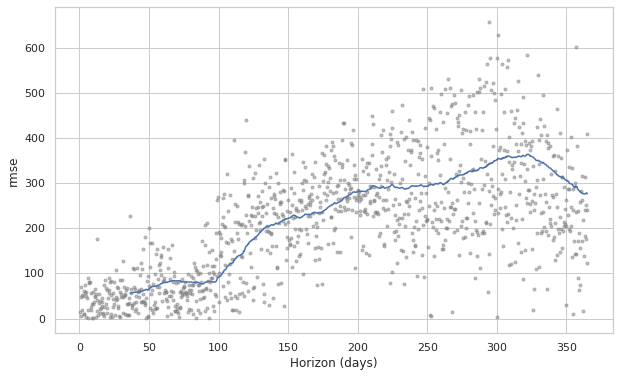

In [490]:
fig = plot_cross_validation_metric(cv_results, metric='rmse')

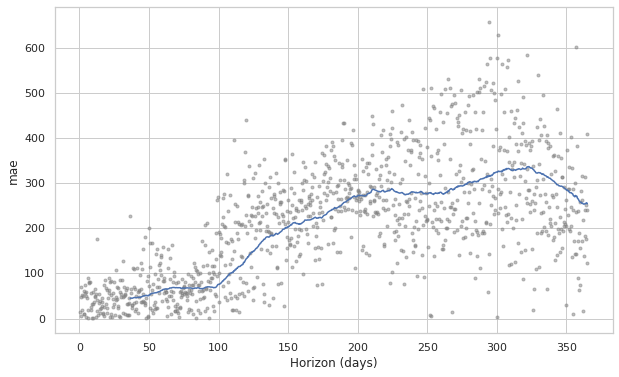

In [491]:
fig = plot_cross_validation_metric(cv_results, metric='mae')

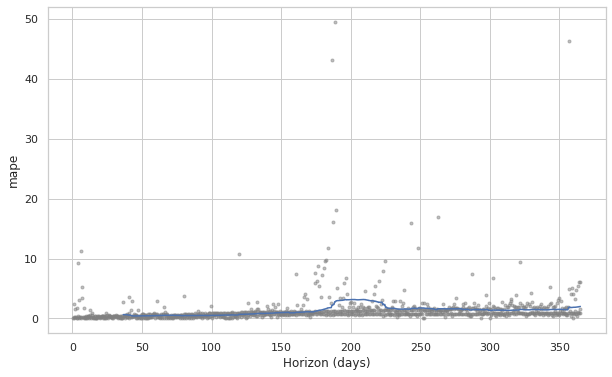

In [492]:
fig = plot_cross_validation_metric(cv_results, metric='mape')

**With final model, make predictions on test set (2019)**

In [25]:
# create prophet object with tuned parameters, fit with entire train data and predict future
m = Prophet(daily_seasonality = 10, # True 5 20 100
            #weekly_seasonality = 5, # True 10 100
            yearly_seasonality = 5, # True 10 20 100!            
            holidays = holidays,
            seasonality_mode = 'multiplicative',
            seasonality_prior_scale = 10, #100
            holidays_prior_scale = 10, #) #100
            changepoint_prior_scale = 0.20) # .20 .15 .25

m.add_seasonality(name='monthly', period=30, fourier_order=10) # 5 100
m.add_seasonality(name='is_weekend', period=7, fourier_order=10, condition_name='is_weekend')
m.add_seasonality(name='not_weekend', period=7, fourier_order=3, condition_name='not_weekend')
m.add_seasonality(name='is_warm', period=30, fourier_order=3, condition_name='is_warm')
m.add_seasonality(name='not_warm', period=30, fourier_order=3, condition_name='not_warm')

m.add_country_holidays(country_name='US')

# fit model to entire training data
m.fit(station_cv)

# predict using test set
future = m.make_future_dataframe(periods=365, freq='d') # 181 # include_history=False) 
future['is_weekend'] = future['ds'].apply(is_weekend)
future['not_weekend'] = ~future['ds'].apply(is_weekend)
future['is_warm'] = future['ds'].apply(is_warm)
future['not_warm'] = ~future['ds'].apply(is_warm)

forecast = m.predict(future)

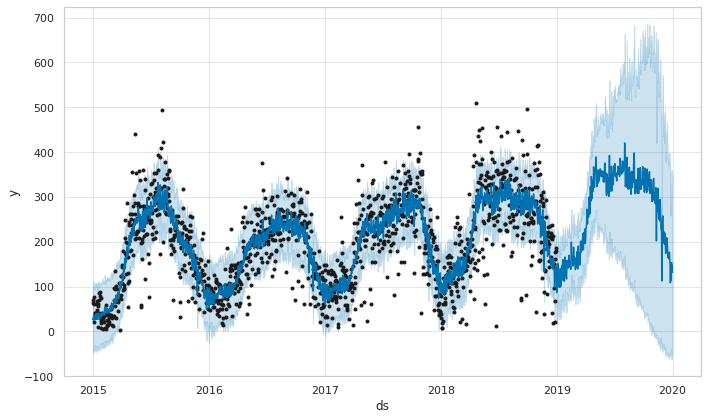

In [494]:
# plot forecast dataframe
fig1 = m.plot(forecast) 

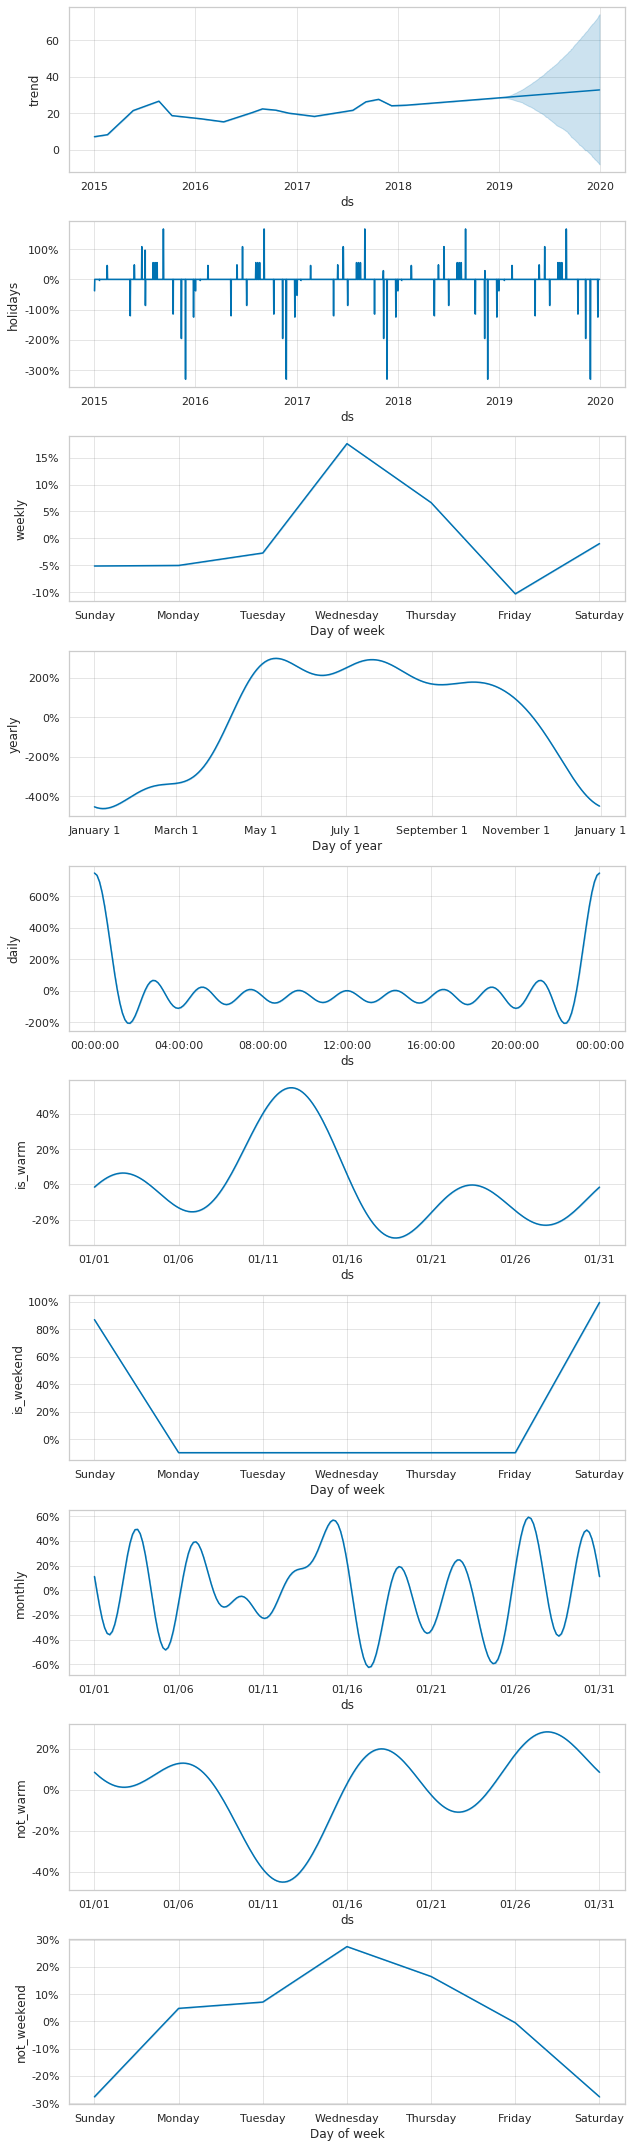

In [495]:
# plot forecast components
fig2 = m.plot_components(forecast)

In [496]:
# merge predictions back to main dataframe
citibike_pred = citibike_df[(citibike_df.station_id == 499) & 
                            (citibike_df.year == 2019)].merge( 
    forecast[['ds','yhat','yhat_lower','yhat_upper']], how='left', left_on=['date'], right_on=['ds'])

citibike_pred = citibike_pred.drop(['ds', 'year', 'month'], axis=1) # 'replace_zeroes'

citibike_pred.yhat = citibike_pred.yhat.apply(np.ceil).astype(int)

citibike_pred['error'] = citibike_pred.yhat - citibike_pred.ride_counts_clean
citibike_pred['error_abs'] = abs(citibike_pred.yhat - citibike_pred.ride_counts_clean).astype(int)
citibike_pred['error_sq'] = ((citibike_pred.yhat - citibike_pred.ride_counts_clean)**2).astype(int)

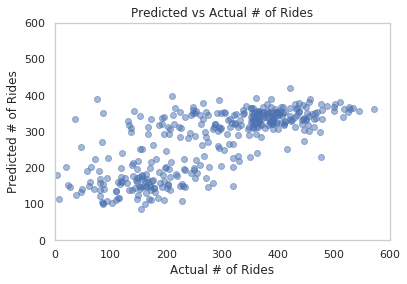

In [497]:
# plot predicted vs actual
plt.scatter(citibike_pred.ride_counts_clean, citibike_pred.yhat, alpha=0.5)
plt.title("Predicted vs Actual # of Rides"), plt.xlabel("Actual # of Rides"), plt.ylabel("Predicted # of Rides")
plt.xlim(0, 600), plt.ylim(0, 600);

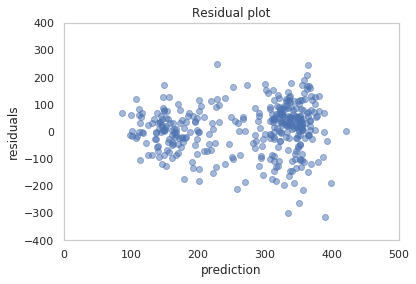

In [498]:
# plot residuals
residuals = citibike_pred.ride_counts_clean - citibike_pred.yhat
plt.scatter(citibike_pred.yhat, residuals, alpha=0.5)
plt.title("Residual plot"), plt.xlabel("prediction"), plt.ylabel("residuals")
plt.xlim(0, 500), plt.ylim(-400, 400);

In [499]:
# evaluation metrics
print("MAE:", mae(citibike_pred.ride_counts_clean, citibike_pred.yhat).round(3))
print("MAPE:", mape(citibike_pred.ride_counts_clean, citibike_pred.yhat).round(3))
print("RMSE:", rmse(citibike_pred.ride_counts_clean, citibike_pred.yhat).round(3))

MAE: 68.855
MAPE: 53.342
RMSE: 88.048


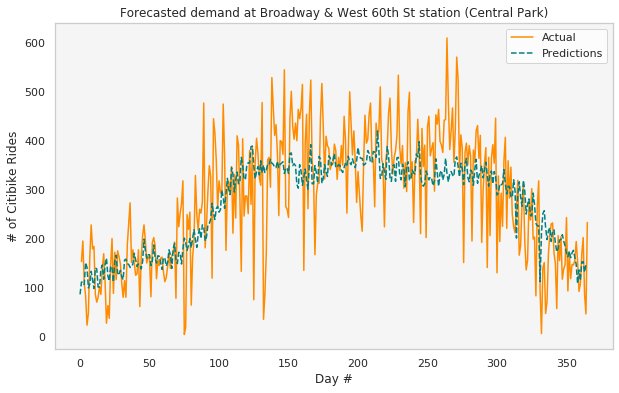

In [500]:
plot_forecast(citibike_pred.ride_counts_clean, citibike_pred.yhat, title='Forecasted demand at Broadway & West 60th St station (Central Park)')

### Forecast all stations

In [52]:
# fit model to each station 

citibike_station = citibike_df.loc[(citibike_df.date < test_start_date), 
                                   ['date', 'is_weekend', 'not_weekend',
                                    'is_warm', 'not_warm', 'ride_counts_clean', 'station_id']] 

last_date = pd.Timestamp(2019, 12, 31) 
delta = timedelta(days = 364)
test_start_date = last_date - delta # test date begins 1/01/2019

forecast_dfs = []

for station in citibike_df.station_id.unique():
    
    station_cv = citibike_station.loc[(citibike_station.station_id == station), 
                                      ['date', 'is_weekend', 'not_weekend', 
                                       'is_warm', 'not_warm', 'ride_counts_clean']]
    station_cv.columns = ['ds', 'is_weekend', 'not_weekend', 'is_warm', 'not_warm', 'y']

    # create prophet object with parameters, fit with entire train data and predict on test set
    m = Prophet(daily_seasonality = 10, 
                #weekly_seasonality = 5,
                yearly_seasonality = 5, 
                holidays = holidays,
                seasonality_mode = 'multiplicative',
                seasonality_prior_scale = 10, 
                holidays_prior_scale = 10,
                changepoint_prior_scale = 0.20)

    m.add_seasonality(name='monthly', period=30, fourier_order=10) 
    m.add_seasonality(name='is_weekend', period=7, fourier_order=10, condition_name='is_weekend')
    m.add_seasonality(name='not_weekend', period=7, fourier_order=3, condition_name='not_weekend')
    m.add_seasonality(name='is_warm', period=30, fourier_order=3, condition_name='is_warm')
    m.add_seasonality(name='not_warm', period=30, fourier_order=3, condition_name='not_warm')
    m.add_country_holidays(country_name='US')
    
    m.fit(station_cv)

    future = m.make_future_dataframe(periods=365, freq='d') # 181 # include_history=False) 
    future['is_weekend'] = future['ds'].apply(is_weekend)
    future['not_weekend'] = ~future['ds'].apply(is_weekend)
    future['is_warm'] = future['ds'].apply(is_warm)
    future['not_warm'] = ~future['ds'].apply(is_warm)

    forecast = m.predict(future)
    forecast = forecast[['ds','yhat']]
    forecast['station_id'] = station 
    
    forecast_dfs.append(forecast)

forecasts = pd.concat(forecast_dfs)
forecasts

,ds,yhat,station_id
0,2015-01-01,11.523320,79
1,2015-01-02,11.135069,79
2,2015-01-03,4.265486,79
3,2015-01-04,4.615415,79
4,2015-01-05,11.749117,79
...,...,...,...
1821,2019-12-27,21.526665,2022
1822,2019-12-28,11.464843,2022
1823,2019-12-29,14.699201,2022
1824,2019-12-30,23.059132,2022


In [60]:
# keep only test data
forecasts = forecasts[forecasts.ds.dt.year == 2019]

In [11]:
# pickle forecasts
#forecasts.to_pickle('data/forecasts.pkl')
forecasts = pd.read_pickle('data/forecasts.pkl')

In [73]:
# merge predictions back to main dataframe
citibike_pred_all = citibike_df.loc[citibike_df.year == 2019,                 ['station_id','date','ride_counts_clean']].merge( 
                        forecasts[['station_id','ds','yhat']], 
                        how='inner', left_on=['date', 'station_id'], right_on=['ds', 'station_id'])

citibike_pred_all = citibike_pred_all.drop(['ds'], axis=1)

citibike_pred_all.yhat = citibike_pred_all.yhat.apply(np.ceil).astype(int)

citibike_pred_all['error'] = citibike_pred_all.yhat - citibike_pred_all.ride_counts_clean
citibike_pred_all['error_abs'] = abs(citibike_pred_all.yhat - citibike_pred_all.ride_counts_clean).astype(int)
citibike_pred_all['error_sq'] = ((citibike_pred_all.yhat - citibike_pred_all.ride_counts_clean)**2).astype(int)

citibike_pred_all.head()

,station_id,date,ride_counts_clean,yhat,error,error_abs,error_sq
0,79,2019-01-01,23,29,6,6,36
1,79,2019-01-02,31,49,18,18,324
2,79,2019-01-03,42,48,6,6,36
3,79,2019-01-04,67,39,-28,28,784
4,79,2019-01-05,17,16,-1,1,1


In [8]:
# pickle all predictions and actuals
#citibike_pred_all.to_pickle('data/citibike_pred_all.pkl')
citibike_pred_all = pd.read_pickle('data/citibike_pred_all.pkl')

In [9]:
citibike_pred_all.head()

,station_id,date,ride_counts_clean,yhat,error,error_abs,error_sq
0,79,2019-01-01,23,29,6,6,36
1,79,2019-01-02,31,49,18,18,324
2,79,2019-01-03,42,48,6,6,36
3,79,2019-01-04,67,39,-28,28,784
4,79,2019-01-05,17,16,-1,1,1


In [93]:
for station in citibike_pred_all.station_id.unique():
    print(station)

79
119
120
127
128
143
144
146
150
151
157
164
168
174
195
216
217
236
237
239
241
242
243
244
245
248
249
252
254
258
259
261
262
264
265
266
268
275
276
278
279
281
282
285
289
295
296
297
301
302
303
305
307
308
309
310
311
313
315
317
320
321
323
324
325
326
327
328
330
331
332
334
335
336
339
340
341
342
343
344
346
350
351
353
354
355
356
358
359
360
361
363
364
366
369
372
373
377
379
380
383
386
387
388
389
391
393
394
396
397
398
399
400
402
406
408
410
411
412
415
416
417
418
419
422
426
427
432
435
436
437
440
445
446
447
454
455
458
459
460
461
466
471
472
473
476
478
479
481
482
484
486
487
491
492
494
496
497
499
501
504
507
514
515
516
517
519
525
528
529
530
531
532
534
536
546
2000
2008
2009
2012
2021
2022


In [96]:
# evaluation metrics

mape_dict = {}
mae_dict = {}
rmse_dict = {}

for station in citibike_pred_all.station_id.unique():
    station_pred = citibike_pred_all.loc[citibike_pred_all.station_id == station,]
    y_actual = station_pred.ride_counts_clean
    y_pred = station_pred.yhat 
    mape_dict[station] = mape(y_actual, y_pred)
    mae_dict[station] = mae(y_actual, y_pred)
    rmse_dict[station] = rmse(y_actual, y_pred)
  
print('Mean MAPE: ', np.array(list(mape_dict.values())).mean().round(5))  
print('Mean MAE: ', np.array(list(mae_dict.values())).mean().round(5))
print('Mean RMSE: ', np.array(list(rmse_dict.values())).mean().round(5)) 

Mean MAPE:  36.9907
Mean MAE:  31.68769
Mean RMSE:  39.96626


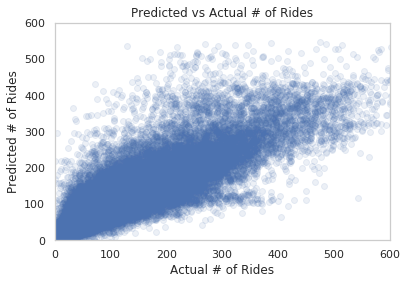

In [99]:
# plot predicted vs actual
plt.scatter(citibike_pred_all.ride_counts_clean, citibike_pred_all.yhat, alpha=0.1)
plt.title("Predicted vs Actual # of Rides"), plt.xlabel("Actual # of Rides"), plt.ylabel("Predicted # of Rides")
plt.xlim(0, 600), plt.ylim(0, 600);

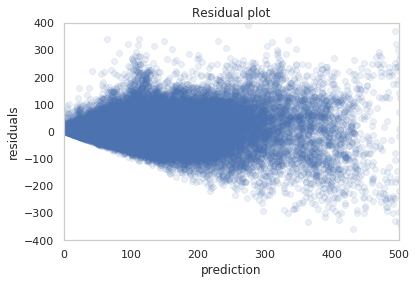

In [100]:
# plot residuals
residuals = citibike_pred_all.ride_counts_clean - citibike_pred_all.yhat
plt.scatter(citibike_pred_all.yhat, residuals, alpha=0.1)
plt.title("Residual plot"), plt.xlabel("prediction"), plt.ylabel("residuals")
plt.xlim(0, 500), plt.ylim(-400, 400);

In [91]:
citibike_pred_all[citibike_pred_all.station_id == 499]

,station_id,date,ride_counts_clean,yhat,error,error_abs,error_sq
57670,499,2019-01-01,154,87,-67,67,4489
57671,499,2019-01-02,196,112,-84,84,7056
57672,499,2019-01-03,110,112,2,2,4
57673,499,2019-01-04,84,107,23,23,529
57674,499,2019-01-05,24,152,128,128,16384
...,...,...,...,...,...,...,...
58030,499,2019-12-27,169,115,-54,54,2916
58031,499,2019-12-28,203,153,-50,50,2500
58032,499,2019-12-29,87,154,67,67,4489
58033,499,2019-12-30,47,132,85,85,7225


TypeError: 'str' object is not callable

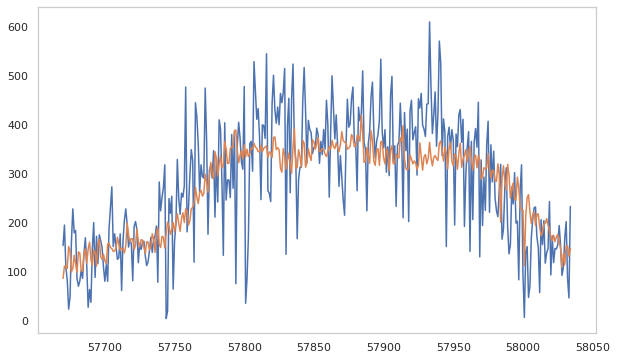

In [129]:
plt.figure(figsize=(10,6))
plt.plot(citibike_pred_all[citibike_pred_all.station_id == 499].ride_counts_clean)
plt.plot(citibike_pred_all[citibike_pred_all.station_id == 499].yhat)
plt.title('Forecasted demand at Broadway & West 60th St station (Central Park)');